#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [61]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [62]:
class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}
        self.bins_amount = 4

    def build_classifier(self, train_features, train_classes):
        #  a priori P(A)
        class_counter =Counter(train_classes)
        self.priors = dict(class_counter)
        total_samples = len(train_classes)
        for key in self.priors:
            self.priors[key] /= total_samples

        # prawdopodobieństwo P(B|A)
        p = np.zeros((len(set(train_classes)), train_features.shape[1], self.bins_amount))
        for class_elem, feature in zip(train_classes, train_features):     
            j=0
            for value in feature:
                p[int(class_elem), j, int(value)] += 1
                j += 1

        # przygotowanie słownika
        self.likelihoods = {key: 1 for key in set(train_classes)}
        for key in self.likelihoods.keys():
            self.likelihoods[key] = {key2: 1 for key2 in range(len(train_features[0]))}
            for key2 in self.likelihoods[key].keys():
                self.likelihoods[key][key2] = {key3: 1 for key3 in range(len(set(train_features.flatten())))}

        
        for class_val in class_counter:
            for feature in train_features:       
                for j in range(len(feature)):
                    self.likelihoods[class_val][j][feature[j]] *= p[class_val, j, int(feature[j])] / class_counter[class_val]


    @staticmethod
    def data_discretization(data:np.ndarray, bins_amount):
        for i in range(data.shape[1]):
            bin_edges = np.linspace(data[:, i].min(), data[:, i].max(), bins_amount)
            data[:, i] = np.digitize(data[:, i], bins=bin_edges, right=True)
        return data

    def predict(self, sample):
        posteriors = {}

        # posteriory P(A|B)
        for class_val, class_prob in self.priors.items():
            posterior = class_prob #class_prob -> a priori
            for i in range(len(sample)):
                posterior *= self.likelihoods[class_val][i][sample[i]]

            posteriors[class_val] = posterior
        return max(posteriors, key=posteriors.get)


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        #  a priori P(A)
        self.priors = dict(Counter(train_classes))
        total_samples = len(train_classes)
        for key in self.priors:
            self.priors[key] /= total_samples

        # prawdopodobieństwo P(B|A)
        for class_val in set(train_classes):
            class_indices = np.where(train_classes == class_val)
            class_data = train_features[class_indices]

            means = np.mean(class_data, axis=0)
            stds = np.std(class_data, axis=0)

            self.likelihoods[class_val] = {'mean': means, 'std': stds}

    @staticmethod
    def normal_dist(x, mean, std):
        exponent = np.exp(-(np.power(x - mean, 2) / (2 * np.power(std, 2))))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

    def predict(self, sample):
        posteriors = {}

        for class_val, class_prob in self.priors.items():
            posterior = class_prob
            for i in range(len(sample)):
                posterior *= GaussianNaiveBayes.normal_dist(sample[i],
                                                              self.likelihoods[class_val]['mean'][i],
                                                              self.likelihoods[class_val]['std'][i])
            posteriors[class_val] = posterior
        return max(posteriors, key=posteriors.get)


In [63]:
def naive_bayes_handler(x_train, x_test, y_train, y_test, bins_amount, verbose):
    nb = NaiveBayes()
    nb.bins_amount = bins_amount
    
    x_train_discrete = NaiveBayes.data_discretization(x_train, bins_amount)

    nb.build_classifier(x_train_discrete, y_train)

    x_test_discrete = NaiveBayes.data_discretization(x_test, bins_amount)

    predictions = [nb.predict(sample) for sample in x_test_discrete]
    predictions2 = [nb.predict(sample) for sample in x_train_discrete]

    print(f'TRAIN Accuracy: {accuracy_score(y_train, predictions2)}')
    print(f'TEST Accuracy: {accuracy_score(y_test, predictions)}')
    if verbose:
        print('Classification Report:')
        print(classification_report(y_test, predictions))
    return (accuracy_score(y_train, predictions2), accuracy_score(y_test, predictions))


def naive_gaussian_bayes_handler(x_train, x_test, y_train, y_test, verbose):
    nb = GaussianNaiveBayes()

    nb.build_classifier(x_train, y_train)

    predictions = [nb.predict(sample) for sample in x_test]
    predictions2 = [nb.predict(sample) for sample in x_train]

    print(f'TRAIN Accuracy: {accuracy_score(y_train, predictions2)}')
    print(f'TEST Accuracy: {accuracy_score(y_test, predictions)}')
    if verbose:
        print('Classification Report:')
        print(classification_report(y_test, predictions))
    return (accuracy_score(y_train, predictions2), accuracy_score(y_test, predictions))


TRAIN Accuracy: 0.9594594594594594
TEST Accuracy: 0.0
TRAIN Accuracy: 0.9583333333333334
TEST Accuracy: 0.8333333333333334
TRAIN Accuracy: 0.9640287769784173
TEST Accuracy: 0.9090909090909091
TRAIN Accuracy: 0.9629629629629629
TEST Accuracy: 0.9333333333333333
TRAIN Accuracy: 0.9615384615384616
TEST Accuracy: 0.9
TRAIN Accuracy: 0.9603174603174603
TEST Accuracy: 0.9166666666666666
TRAIN Accuracy: 0.9669421487603306
TEST Accuracy: 0.9655172413793104
TRAIN Accuracy: 0.9572649572649573
TEST Accuracy: 0.9696969696969697
TRAIN Accuracy: 0.9553571428571429
TEST Accuracy: 0.9736842105263158
TRAIN Accuracy: 0.9532710280373832
TEST Accuracy: 0.9767441860465116
TRAIN Accuracy: 0.941747572815534
TEST Accuracy: 0.9787234042553191
TRAIN Accuracy: 0.9591836734693877
TEST Accuracy: 0.9807692307692307
TRAIN Accuracy: 0.9574468085106383
TEST Accuracy: 0.9642857142857143
TRAIN Accuracy: 0.9438202247191011
TEST Accuracy: 0.9344262295081968
TRAIN Accuracy: 0.9411764705882353
TEST Accuracy: 0.9076923076923

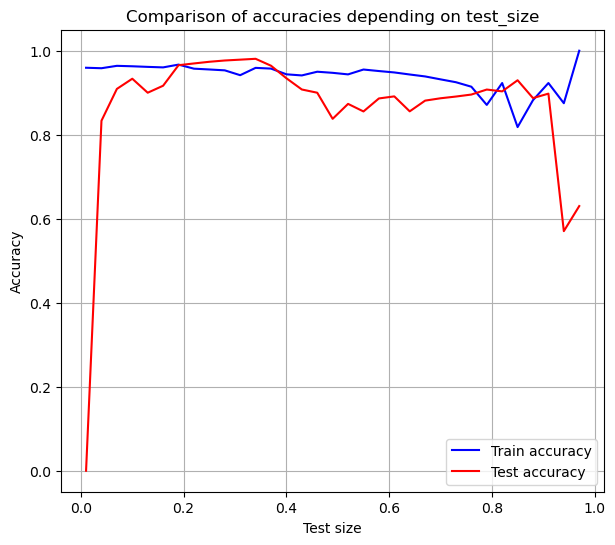

In [64]:
iris = load_iris()

x = iris.data
y = iris.target
train_accuracy = []
test_accuracy = []
test_sizes = []
i=0.01
while i < 1.0:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=i, random_state=153)
    a_train, a_test = naive_bayes_handler(x_train, x_test, y_train, y_test, bins_amount=4, verbose=0)
    train_accuracy.append(a_train)
    test_accuracy.append(a_test)
    test_sizes.append(i)
    i += 0.03

plt.figure(figsize=(7, 6))
plt.plot(test_sizes, train_accuracy, color='blue', label='Train accuracy')

plt.xlabel('Test size')
plt.ylabel('Accuracy')
plt.title('Comparison of accuracies depending on test_size')

plt.plot(test_sizes, test_accuracy, color='red', label='Test accuracy')

plt.legend()
plt.grid(True)
plt.show()



TRAIN Accuracy: 0.9594594594594594
TEST Accuracy: 1.0
TRAIN Accuracy: 0.9574468085106383
TEST Accuracy: 1.0
TRAIN Accuracy: 0.9624060150375939
TEST Accuracy: 0.9411764705882353
TRAIN Accuracy: 0.96
TEST Accuracy: 0.96
TRAIN Accuracy: 0.9576271186440678
TEST Accuracy: 0.96875
TRAIN Accuracy: 0.954954954954955
TEST Accuracy: 0.9743589743589743
TRAIN Accuracy: 0.9611650485436893
TEST Accuracy: 0.9574468085106383
TRAIN Accuracy: 0.96875
TEST Accuracy: 0.9444444444444444
TRAIN Accuracy: 0.9659090909090909
TEST Accuracy: 0.9516129032258065
TRAIN Accuracy: 0.9753086419753086
TEST Accuracy: 0.9420289855072463
TRAIN Accuracy: 0.9863013698630136
TEST Accuracy: 0.935064935064935
TRAIN Accuracy: 1.0
TEST Accuracy: 0.9294117647058824
TRAIN Accuracy: 1.0
TEST Accuracy: 0.9347826086956522
TRAIN Accuracy: 0.98
TEST Accuracy: 0.94
TRAIN Accuracy: 0.9767441860465116
TEST Accuracy: 0.9532710280373832
TRAIN Accuracy: 1.0
TEST Accuracy: 0.9478260869565217
TRAIN Accuracy: 1.0
TEST Accuracy: 0.95901639344262

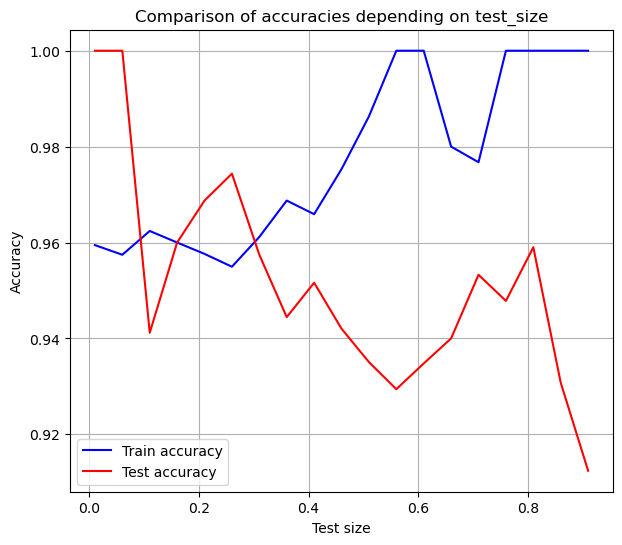

In [65]:
iris = load_iris()

x = iris.data
y = iris.target
train_accuracy = []
test_accuracy = []
test_sizes = []
i=0.01
while i < 0.95:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=i, random_state=13)
    a_train, a_test = naive_gaussian_bayes_handler(x_train, x_test, y_train, y_test, 0)
    train_accuracy.append(a_train)
    test_accuracy.append(a_test)
    test_sizes.append(i)
    i += 0.05

plt.figure(figsize=(7, 6))
plt.plot(test_sizes, train_accuracy, color='blue', label='Train accuracy')

plt.xlabel('Test size')
plt.ylabel('Accuracy')
plt.title('Comparison of accuracies depending on test_size')

plt.plot(test_sizes, test_accuracy, color='red', label='Test accuracy')

plt.legend()
plt.grid(True)
plt.show()

TRAIN Accuracy: 0.375
TEST Accuracy: 0.6666666666666666
TRAIN Accuracy: 0.7916666666666666
TEST Accuracy: 0.7333333333333333
TRAIN Accuracy: 0.95
TEST Accuracy: 0.9666666666666667
TRAIN Accuracy: 0.9166666666666666
TEST Accuracy: 0.8666666666666667
TRAIN Accuracy: 0.95
TEST Accuracy: 0.7333333333333333


TRAIN Accuracy: 0.9666666666666667
TEST Accuracy: 0.9
TRAIN Accuracy: 0.9333333333333333
TEST Accuracy: 0.9333333333333333
TRAIN Accuracy: 0.9666666666666667
TEST Accuracy: 0.7666666666666667
TRAIN Accuracy: 0.9833333333333333
TEST Accuracy: 0.8666666666666667


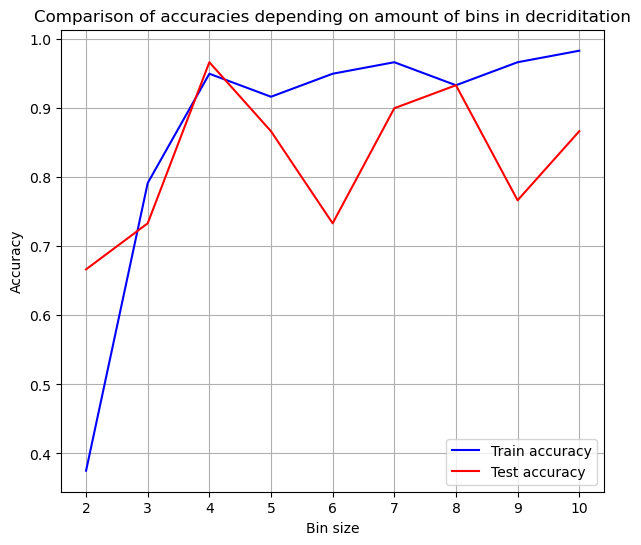

In [66]:
iris = load_iris()

x = iris.data
y = iris.target
train_accuracy = []
test_accuracy = []
bin_sizes = []
for i in range(2, 11):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=153)
    a_train, a_test = naive_bayes_handler(x_train, x_test, y_train, y_test, bins_amount=i, verbose=0)
    train_accuracy.append(a_train)
    test_accuracy.append(a_test)
    bin_sizes.append(i)

plt.figure(figsize=(7, 6))
plt.plot(bin_sizes, train_accuracy, color='blue', label='Train accuracy')

plt.xlabel('Bin size')
plt.ylabel('Accuracy')
plt.title('Comparison of accuracies depending on amount of bins in decriditation')

plt.plot(bin_sizes, test_accuracy, color='red', label='Test accuracy')

plt.legend()
plt.grid(True)
plt.show()



In [67]:
iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

temp = naive_bayes_handler(x_train, x_test, y_train, y_test, bins_amount=4, verbose=1)


TRAIN Accuracy: 0.9583333333333334
TEST Accuracy: 0.9666666666666667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92         6
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



In [68]:
iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=173)

temp = naive_gaussian_bayes_handler(x_train, x_test, y_train, y_test, 1)


TRAIN Accuracy: 0.975
TEST Accuracy: 0.9
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.75      1.00      0.86         9
           2       1.00      0.79      0.88        14

    accuracy                           0.90        30
   macro avg       0.92      0.93      0.91        30
weighted avg       0.93      0.90      0.90        30

